## Algoritmo t-SNE

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


df = pd.read_csv('data/breast-cancer-wisconsin.csv')

print("Dimensiones del dataset:", df.shape)
print("\nDistribución de diagnósticos:")
print(df['diagnosis'].value_counts())

Dimensiones del dataset: (569, 33)

Distribución de diagnósticos:
diagnosis
B    357
M    212
Name: count, dtype: int64


## Preprocesamiento
- Se elimina 'id' porque es un identificador sin valor informativo.
- Se elimina 'diagnosis' porque es la variable objetivo (no la usamos para entrenar)
- Le damos a t-SNE solo las features numéricas (medidas del tumor) — sin decirle qué es maligno y qué es benigno

In [12]:
X = df.drop(columns=['id', 'diagnosis'])
y = df['diagnosis']  # M = Maligno, B = Benigno

print("Features utilizadas:", X.shape[1])
print("Muestras:", X.shape[0])

# Verificar valores nulos
print("\nValores nulos por columna:")
print(X.isnull().sum().sum(), "valores nulos totales")

# Eliminar columnas completamente vacías
X = X.dropna(axis=1, how='all')
print("Nulos restantes:", X.isnull().sum().sum())

# Normalizar: t-SNE es sensible a la escala de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Features utilizadas: 31
Muestras: 569

Valores nulos por columna:
569 valores nulos totales
Nulos restantes: 0


## Aplicar t-SNE
Parámetros:
- n_components=2: proyectar a 2D para visualización
- perplexity=30: valor estándar recomendado para datasets medianos.
  Representa el número efectivo de vecinos que el algoritmo considera por punto
- n_iter=1000: iteraciones de optimización (mínimo recomendado)
- random_state=42: para reproducibilidad (t-SNE es estocástico)

In [13]:
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Guardar en DataFrame para graficar
tsne_df = pd.DataFrame(X_tsne, columns=['Componente 1', 'Componente 2'])
tsne_df['Diagnóstico'] = y.values
tsne_df['Diagnóstico_label'] = tsne_df['Diagnóstico'].map({'M': 'Maligno', 'B': 'Benigno'})

print("Forma del resultado t-SNE:", X_tsne.shape)
tsne_df.head()

Forma del resultado t-SNE: (569, 2)


,Componente 1,Componente 2,Diagnóstico,Diagnóstico_label
0,28.455524,-3.792385,M,Maligno
1,16.015896,-13.852530,M,Maligno
2,24.698252,-7.632042,M,Maligno
3,23.351952,6.404766,M,Maligno
4,22.468880,-17.950768,M,Maligno


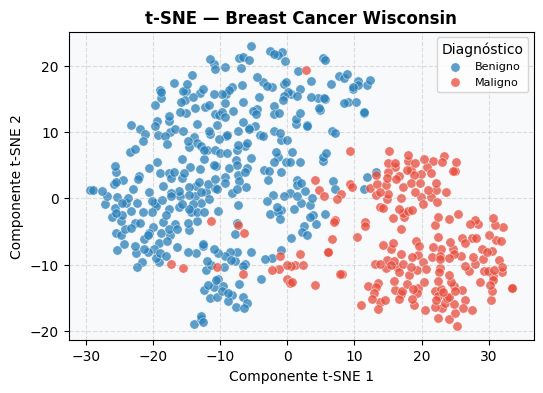

In [16]:
# Visualizar

fig, ax = plt.subplots(figsize=(6, 4))

colores = {'Maligno': '#e74c3c', 'Benigno': '#2980b9'}

for tipo, grupo in tsne_df.groupby('Diagnóstico_label'):
    ax.scatter(
        grupo['Componente 1'],
        grupo['Componente 2'],
        c=colores[tipo],
        label=tipo,
        alpha=0.75,
        s=45,
        edgecolors='white',
        linewidths=0.4
    )

ax.set_title('t-SNE — Breast Cancer Wisconsin',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Componente t-SNE 1', fontsize=10)
ax.set_ylabel('Componente t-SNE 2', fontsize=10)
ax.legend(title='Diagnóstico', fontsize=8)
ax.grid(True, linestyle='--', alpha=0.4)
ax.set_facecolor('#f8f9fa')
plt.show()

## Comparacion t-SNE vs PCA
- PCA es lineal y preserva varianza global
- t-SNE es no lineal y preserva estructura local

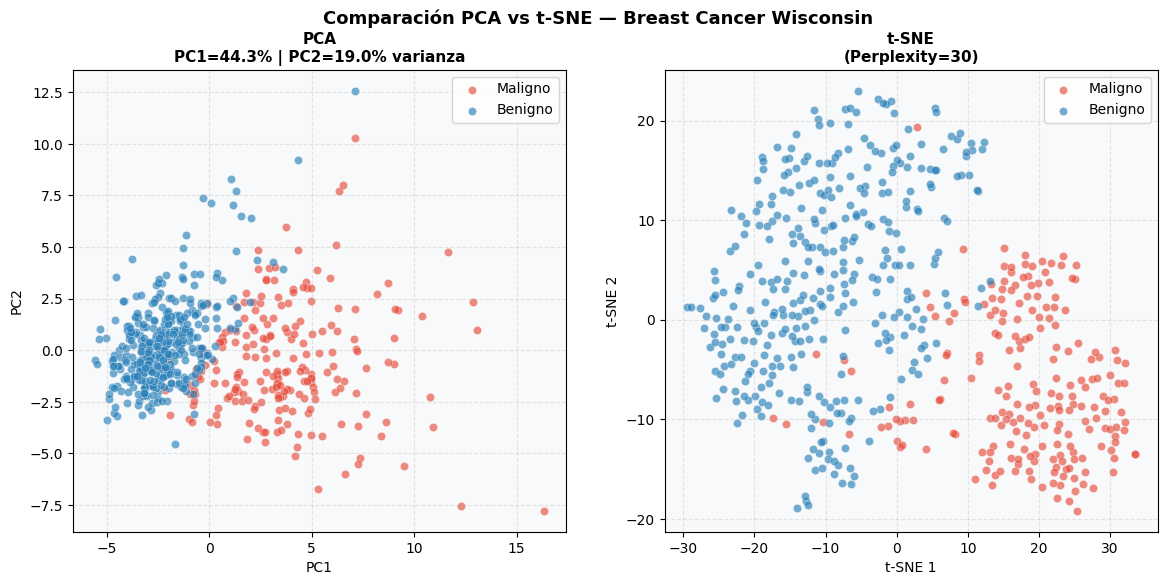

In [20]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for diag in ['M', 'B']:
    mask = y.values == diag
    label = 'Maligno' if diag == 'M' else 'Benigno'
    
    # PCA
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=colores_diag[diag], label=label,
                    alpha=0.65, s=35, edgecolors='white', linewidths=0.3)
    
    # t-SNE
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                    c=colores_diag[diag], label=label,
                    alpha=0.65, s=35, edgecolors='white', linewidths=0.3)

# Varianza explicada de PCA
var_exp = pca.explained_variance_ratio_
axes[0].set_title(f'PCA\nPC1={var_exp[0]*100:.1f}% | PC2={var_exp[1]*100:.1f}% varianza', fontsize=11, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_facecolor('#f8f9fa')

axes[1].set_title('t-SNE\n(Perplexity=30)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)
axes[1].set_facecolor('#f8f9fa')

fig.suptitle('Comparación PCA vs t-SNE — Breast Cancer Wisconsin',
             fontsize=13, fontweight='bold')
plt.show()



In [24]:
from IPython.display import display

resumen = tsne_df.groupby('Diagnóstico_label')[['Componente 1', 'Componente 2']].agg(['mean', 'std']).round(3)
resumen.columns = ['C1 Media', 'C1 Std', 'C2 Media', 'C2 Std']

print("Estadísticas de las proyecciones t-SNE por clase")
display(resumen)

conteo = df['diagnosis'].value_counts().reset_index()
conteo.columns = ['Diagnóstico', 'Cantidad']
conteo['Porcentaje'] = (conteo['Cantidad'] / len(df) * 100).round(1)
conteo['Diagnóstico'] = conteo['Diagnóstico'].map({'M': 'Maligno', 'B': 'Benigno'})

print("Distribución del dataset")
display(conteo)

Estadísticas de las proyecciones t-SNE por clase


,C1 Media,C1 Std,C2 Media,C2 Std
Diagnóstico_label,,,,
Benigno,-9.512000,9.633,4.017,9.757
Maligno,17.919001,9.528,-6.659,7.035


Distribución del dataset


,Diagnóstico,Cantidad,Porcentaje
0,Benigno,357,62.7
1,Maligno,212,37.3
